# Bibliotecas

In [1]:
import pandas as pd
# ------ Visualizar todos os arquivo da pasta
from os import chdir, getcwd, listdir
from os.path import isfile

#! pip install rasterio
import rasterio

#! pip install geopandas
import geopandas as gpd

# ------- Para a correlação
from scipy import stats

# --------- Plotar o grafico
import matplotlib.pyplot as plt


# Funções

In [2]:
def extrairPixel_(imagem,arquivoDeCoordenadas,mes,ano,variavelAlvo):
    # Read points from shapefile
    #arquivoDeCoordenadas = gdfCoordenadas[(gdfCoordenadas['CODIGO']==codigo)
    arquivoDeCoordenadas = arquivoDeCoordenadas[arquivoDeCoordenadas.columns.tolist()]
    arquivoDeCoordenadas.index = range(len(arquivoDeCoordenadas))
    coords = [(x,y) for x, y in zip(arquivoDeCoordenadas.Longitude, arquivoDeCoordenadas.Latitude)]
    arquivoDeCoordenadas['MES'] = mes
    arquivoDeCoordenadas['ANO'] = ano
    arquivoDeCoordenadas[variavelAlvo] = [x[0] for x in imagem.sample(coords)]
    arquivoDeCoordenadas=pd.DataFrame(arquivoDeCoordenadas)
    return arquivoDeCoordenadas

# Carregando os dados 

In [3]:
# ---------- Carregando os dados da ANA
ANA = pd.read_csv(r"Gauges\ANA.csv")
#display(ANA)


# --------- Transformando o codigo para texto
ANA['CODIGO'] = ANA['CODIGO'].astype(str)
ANA['Latitude'] = ANA['Latitude'].astype(str)
ANA['Longitude'] = ANA['Longitude'].astype(str)

In [4]:
# -------- Obtendo apenas as estações sem falhas da ANA no periodo acima de 2001
n_observacoesAna = len(ANA[(ANA['PERIODO']>="2001-01-01") &
                          (ANA['PERIODO']<="2001-12-31")]['PERIODO'].unique())
ANA_estações_completas = ANA[(ANA['PERIODO']>="2001-01-01") &
                            (ANA['PERIODO']<="2001-12-31")].groupby('CODIGO').count().sort_values('Unnamed: 0', ascending = False).reset_index()
ANA_estações_completas = ANA_estações_completas[ANA_estações_completas['Unnamed: 0']==n_observacoesAna]['CODIGO'].unique()


In [5]:
# -------- Eliminar as estações que tiveram menos de 30 observações no periodo
# ---------- Transformando a coluna PERIODO para o formato datetime
ANA['PERIODO'] = pd.to_datetime(ANA['PERIODO'])

# ---------- Criando os campos MES e ANO
ANA['MES'] = ANA['PERIODO'].dt.month
ANA['ANO'] = ANA['PERIODO'].dt.year



ANA_agrupado_por_mes = ANA[['CODIGO','ANO','MES','PRECIPITACAO', 
                            'Latitude','Longitude']].groupby(['CODIGO','ANO','MES', 'Latitude','Longitude']).sum().reset_index()


# ------- Filtrando os dados no periodo de 2001 a 2022
ANA_agrupado_por_mes = ANA_agrupado_por_mes[(ANA_agrupado_por_mes['ANO']==2001)]
# ---------- Calculando o numero de ocorrencias de cada estação
ocorrencias_ANA = ANA_agrupado_por_mes.groupby(['CODIGO']).count().reset_index()



ANA_agrupado_por_mes['FONTE'] = 'ANA'

# ------- Concatenando os dados
df_agrupado_por_mes = ANA_agrupado_por_mes.reset_index(drop=True)

df_agrupado_por_mes['MES'] = df_agrupado_por_mes['MES'].astype(str)
df_agrupado_por_mes['ANO'] = df_agrupado_por_mes['ANO'].astype(str)

df_agrupado_por_mes.loc[~((df_agrupado_por_mes['MES']=='10') | 
                       (df_agrupado_por_mes['MES']=='11') | 
                       (df_agrupado_por_mes['MES']=='12')), "MES"] = "0" + df_agrupado_por_mes['MES']

df_agrupado_por_mes

,CODIGO,ANO,MES,Latitude,Longitude,PRECIPITACAO,FONTE
0,735050,2001,01,-7.9681,-35.1567,40.9,ANA
1,735050,2001,02,-7.9681,-35.1567,11.3,ANA
2,735050,2001,03,-7.9681,-35.1567,71.3,ANA
3,735050,2001,04,-7.9681,-35.1567,144.3,ANA
4,735050,2001,05,-7.9681,-35.1567,20.7,ANA
...,...,...,...,...,...,...,...
504,937031,2001,08,-9.1056,-37.1317,67.7,ANA
505,937031,2001,09,-9.1056,-37.1317,0.0,ANA
506,937031,2001,10,-9.1056,-37.1317,30.2,ANA
507,937031,2001,11,-9.1056,-37.1317,15.0,ANA


In [6]:
#Criar geopandas geodataframe 
df_Estacoes_shapefile=gpd.GeoDataFrame(df_agrupado_por_mes,geometry=gpd.points_from_xy(
    df_agrupado_por_mes.Longitude,df_agrupado_por_mes.Latitude))


# ---- Convertendo as colunas Latitude e Longitude para o formato float
df_Estacoes_shapefile["Latitude"] = df_Estacoes_shapefile["Latitude"].astype("float")
df_Estacoes_shapefile["Longitude"] = df_Estacoes_shapefile["Longitude"].astype("float")

# Correlação dos dados observados com os dados medidos

In [10]:
# ---- diretorio dos arquivos
path = r"\GPM"

chdir(path)
print(getcwd())

# --------- Criando uma lista para visualizar todos os arquivos
todosOsArquivos = []
for c in listdir():
    if isfile(c):
        todosOsArquivos.append(c)

# ---- criar um dataframe com a listagem de todos os arquivos
df_arquivosDiretorio = pd.DataFrame()

# ---- criando uma coluna com o nomes dos arquivos
df_arquivosDiretorio["todosOsArquivos"]=todosOsArquivos

# ------ Aplicando um filtro de acordo com o nome do arquivo
df_arquivosDiretorio = df_arquivosDiretorio[(df_arquivosDiretorio["todosOsArquivos"].str.contains("GIOVANNI")) &
                                           (~(df_arquivosDiretorio['todosOsArquivos'].str.endswith('(1).tif')))]


# ----- Visualizando todos os arquivos no diretorio
#print(df_arquivosDiretorio)

# -------- Entendendo o padrão de escrita dos dados e obtendo as colunas de ANO E MES
df_arquivosDiretorio["ANO"] = df_arquivosDiretorio['todosOsArquivos'].str.split("-", expand = True)[2].str.split(".", expand = True)[0].str[0:4]
df_arquivosDiretorio["MES"] =df_arquivosDiretorio['todosOsArquivos'].str.split("-", expand = True)[2].str.split(".", expand = True)[0].str[4:6]

# ------- Ordenando os dados por ANO e MES
df_arquivosDiretorio = df_arquivosDiretorio.sort_values(["ANO","MES"]).reset_index(drop=True)

# ------- Utilizando a função ExtractPixel

# ----- Criando um df vazio
df_GPM = pd.DataFrame()
for i in range(df_arquivosDiretorio.shape[0]):
    df_ = extrairPixel_(imagem = rasterio.open(df_arquivosDiretorio['todosOsArquivos'][i]),
                             arquivoDeCoordenadas = df_Estacoes_shapefile[df_Estacoes_shapefile['MES']==df_Estacoes_shapefile['MES'].unique()[i]],
              mes = df_arquivosDiretorio['MES'][i],
              ano = df_arquivosDiretorio['ANO'][i],
              variavelAlvo = "PRECIPITACAO GPM")
    df_GPM = pd.concat([df_GPM,df_])
    
display(df_GPM)    

H:\Meu Drive\Mestrado\PESQUISA\01_SCRIPTS\Correlação de Mann Kendall\GPM


,CODIGO,ANO,MES,Latitude,Longitude,PRECIPITACAO,FONTE,geometry,PRECIPITACAO GPM
0,735050,2001,01,-7.9681,-35.1567,40.9,ANA,POINT (-35.15670 -7.96810),34.224003
1,735066,2001,01,-7.8942,-35.1733,45.2,ANA,POINT (-35.17330 -7.89420),34.224003
2,735067,2001,01,-7.9428,-35.6342,25.4,ANA,POINT (-35.63420 -7.94280),24.552000
3,735100,2001,01,-7.8789,-35.4519,63.2,ANA,POINT (-35.45190 -7.87890),28.272001
4,735157,2001,01,-7.8428,-35.1825,41.8,ANA,POINT (-35.18250 -7.84280),34.224003
...,...,...,...,...,...,...,...,...,...
37,839034,2001,12,-8.5203,-39.6408,85.0,ANA,POINT (-39.64080 -8.52030),125.736008
38,839035,2001,12,-8.8042,-39.8225,66.5,ANA,POINT (-39.82250 -8.80420),113.832008
39,840010,2001,12,-8.6161,-39.9994,32.2,ANA,POINT (-39.99940 -8.61610),111.600006
40,840015,2001,12,-8.9989,-40.2731,72.0,ANA,POINT (-40.27310 -8.99890),92.256004


# Correlação

In [13]:
df = df_GPM.sort_values(["CODIGO","ANO", "MES"]).reset_index(drop=True)

# ------- Obtendo as estatisticas
for estacoes in df["CODIGO"].unique():
    
    # ------- Teste de shapiro
    df.loc[(df["CODIGO"]==estacoes) &
           (stats.shapiro(df['PRECIPITACAO GPM'])[1] < 0.05), "DISTRIBUIÇÃO"] = "NÃO NORMAL"
    
    # -------- Correlação de kendall dados que os dados nao sao normais
    df.loc[(df["CODIGO"]==estacoes) & (df["DISTRIBUIÇÃO"]=="NÃO NORMAL"), 
           "tau de Kendall"] =stats.kendalltau(df.loc[(df["CODIGO"]==estacoes) & 
                                                      (df["DISTRIBUIÇÃO"]=="NÃO NORMAL")]['PRECIPITACAO GPM'],
                                               df.loc[(df["CODIGO"]==estacoes) & 
                                                      (df["DISTRIBUIÇÃO"]=="NÃO NORMAL")]['PRECIPITACAO'])[0]
    
    df.loc[(df["CODIGO"]==estacoes) & (df["DISTRIBUIÇÃO"]=="NÃO NORMAL"), 
           "p-valor"] =stats.kendalltau(df.loc[(df["CODIGO"]==estacoes) & 
                                               (df["DISTRIBUIÇÃO"]=="NÃO NORMAL")]['PRECIPITACAO GPM'],
                                                df.loc[(df["CODIGO"]==estacoes) & (df["DISTRIBUIÇÃO"]=="NÃO NORMAL")]['PRECIPITACAO'])[1]
    
    # ------ Interpretação do teste
    df.loc[(df["CODIGO"]==estacoes) & (df["DISTRIBUIÇÃO"]=="NÃO NORMAL") & (df["p-valor"]<=0.05), "CORRELAÇÃO SIG (95%)"] = "SIM"

df.drop_duplicates("CODIGO")[["DISTRIBUIÇÃO","tau de Kendall","p-valor","CORRELAÇÃO SIG (95%)"]]

df.loc[df["tau de Kendall"]==1, "CORRELAÇÃO"] = "Perfeita positiva"
df.loc[(df["tau de Kendall"]>=0.7) &  (df["tau de Kendall"]<1), "CORRELAÇÃO"] = "Forte positiva"
df.loc[(df["tau de Kendall"]>=0.4) &  (df["tau de Kendall"]<0.7), "CORRELAÇÃO"] = "Moderada positiva"
df.loc[(df["tau de Kendall"]>=0.1) &  (df["tau de Kendall"]<0.4), "CORRELAÇÃO"] = "Fraca positiva"
df.loc[(df["tau de Kendall"]>0) &  (df["tau de Kendall"]<0.1), "CORRELAÇÃO"] = "Ínfima positiva"
df.loc[df["tau de Kendall"]==0, "CORRELAÇÃO"] = "Nula"
df.loc[df["tau de Kendall"]==-1, "CORRELAÇÃO"] = "Perfeita negativa"
df.loc[(df["tau de Kendall"]>=-0.7) &  (df["tau de Kendall"]<-1), "CORRELAÇÃO"] = "Forte negativa"
df.loc[(df["tau de Kendall"]<=-0.4) &  (df["tau de Kendall"]<-0.7), "CORRELAÇÃO"] = "Moderada negativa"
df.loc[(df["tau de Kendall"]<=-0.1) &  (df["tau de Kendall"]<-0.4), "CORRELAÇÃO"] = "Fraca negativa"
df.loc[(df["tau de Kendall"]<0) &  (df["tau de Kendall"]>-0.1), "CORRELAÇÃO"] = "Ínfima negativa"    

# Visualização da correlação

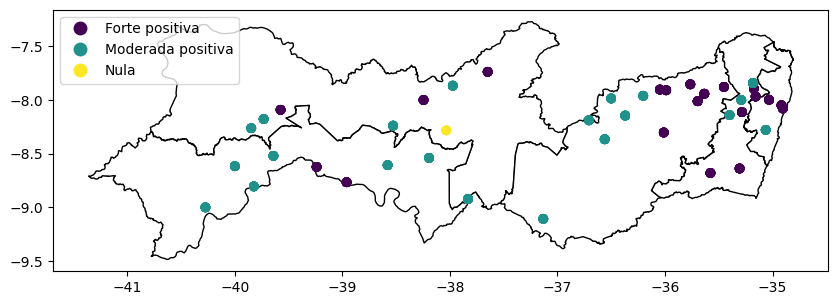

In [14]:
# --------- importando o shapefile das mesorregiões de Pernambuco
mesorregioes_PE = gpd.read_file(r"malha_mesorregiões_PE\MESORREGIOES_PE_2020.shp")

# # -------- Fazendo o merge com a latitude e longitude
# df_inmet = df_inmet.merge(estacoesPE[['Codigo Estacao', "Latitude", "Longitude" ]], 
#                                                               how = 'inner', left_on = 'CODIGO', 
#                                 right_on = 'Code')

#Criar geopandas geodataframe 
estaticas_df=gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(
    df.Longitude,df.Latitude))

# --------- Plotando estações meteorologicas
fig, ax = plt.subplots(figsize=(10,10))
base = mesorregioes_PE.plot(ax=ax, color = 'white', edgecolor = 'black')

# ---------- Remover as estações que nao foi possivel correlacionar
estaticas_df.plot(ax=base, column = 'CORRELAÇÃO', legend = True, cmap = 'viridis')       
plt.show()